In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
dataset = pd.read_csv("pulsar_stars.csv")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
Mean of the integrated profile                  17898 non-null float64
Standard deviation of the integrated profile    17898 non-null float64
Excess kurtosis of the integrated profile       17898 non-null float64
Skewness of the integrated profile              17898 non-null float64
Mean of the DM-SNR curve                        17898 non-null float64
Standard deviation of the DM-SNR curve          17898 non-null float64
Excess kurtosis of the DM-SNR curve             17898 non-null float64
Skewness of the DM-SNR curve                    17898 non-null float64
target_class                                    17898 non-null int64
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


## EDA

In [3]:
import collections
print(collections.Counter(dataset['target_class']))

Counter({0: 16259, 1: 1639})


Looks like ~10% of the total data belongs positive class.

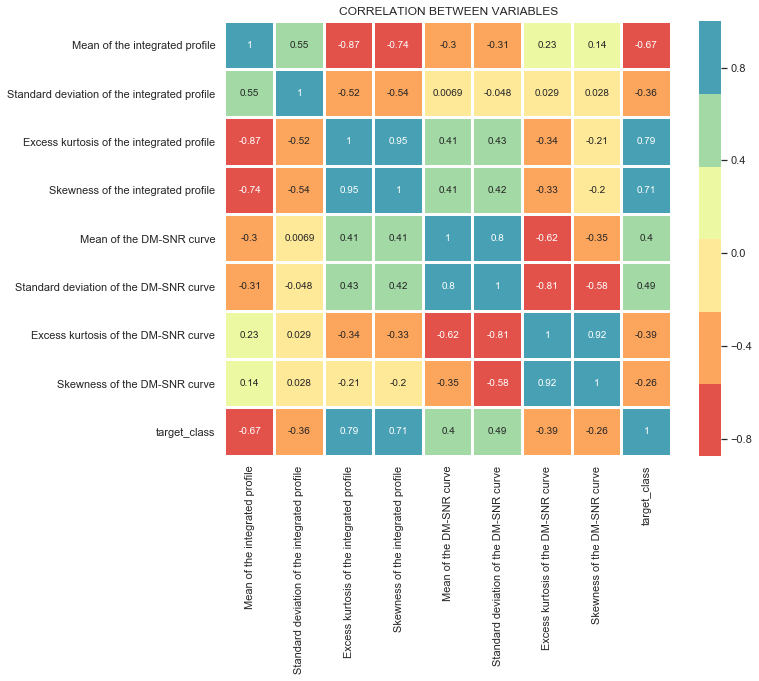

In [4]:
correlation = dataset.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation,annot=True,
            cmap=sns.color_palette("Spectral"),
            linewidth=2,edgecolor="k")
plt.title("CORRELATION BETWEEN VARIABLES")
plt.show()

In [5]:
cols = list(dataset.columns)
cols.remove("target_class")
print(cols)

['Mean of the integrated profile', 'Standard deviation of the integrated profile', 'Excess kurtosis of the integrated profile', 'Skewness of the integrated profile', 'Mean of the DM-SNR curve', 'Standard deviation of the DM-SNR curve', 'Excess kurtosis of the DM-SNR curve', 'Skewness of the DM-SNR curve']


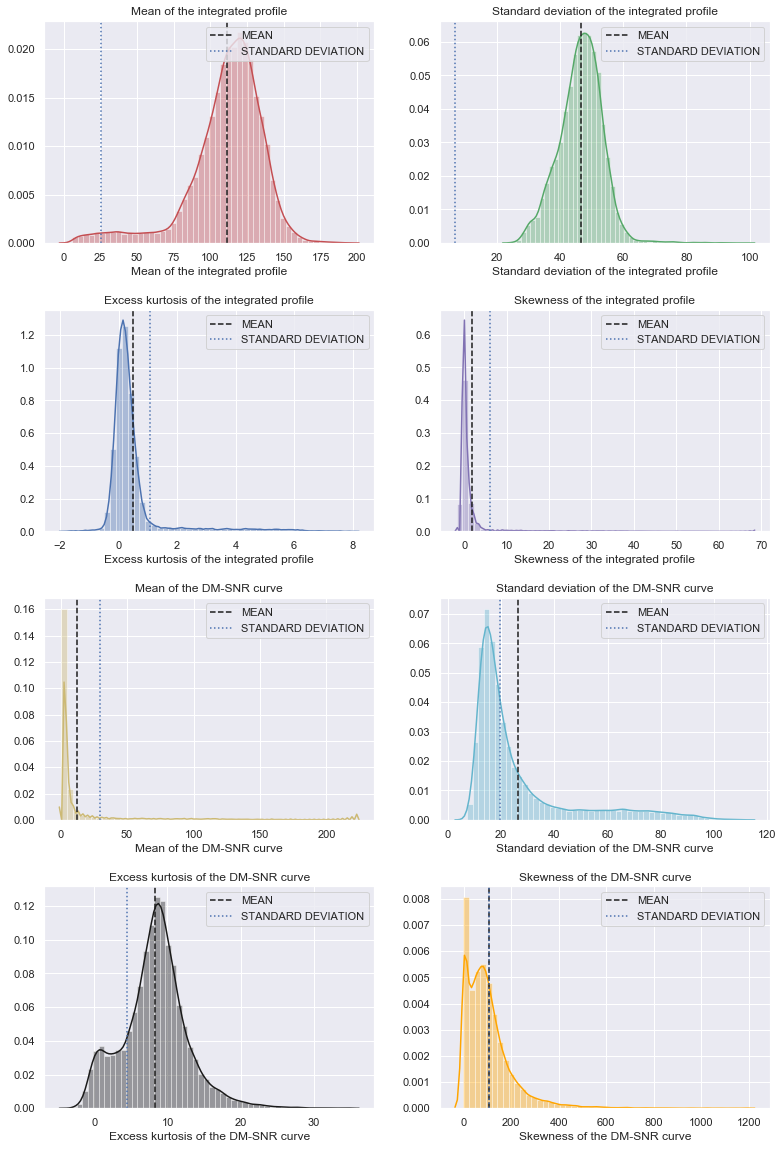

In [6]:
import itertools
columns = cols.copy()
length  = len(columns)
colors  = ["r","g","b","m","y","c","k","orange"] 

plt.figure(figsize=(13,20))
for i,j,k in itertools.zip_longest(columns,range(length),colors):
    plt.subplot(length/2,length/4,j+1)
    sns.distplot(dataset[i],color=k)
    plt.title(i)
    plt.subplots_adjust(hspace = .3)
    plt.axvline(dataset[i].mean(),color = "k",linestyle="dashed",label="MEAN")
    plt.axvline(dataset[i].std(),color = "b",linestyle="dotted",label="STANDARD DEVIATION")
    plt.legend(loc="upper right")

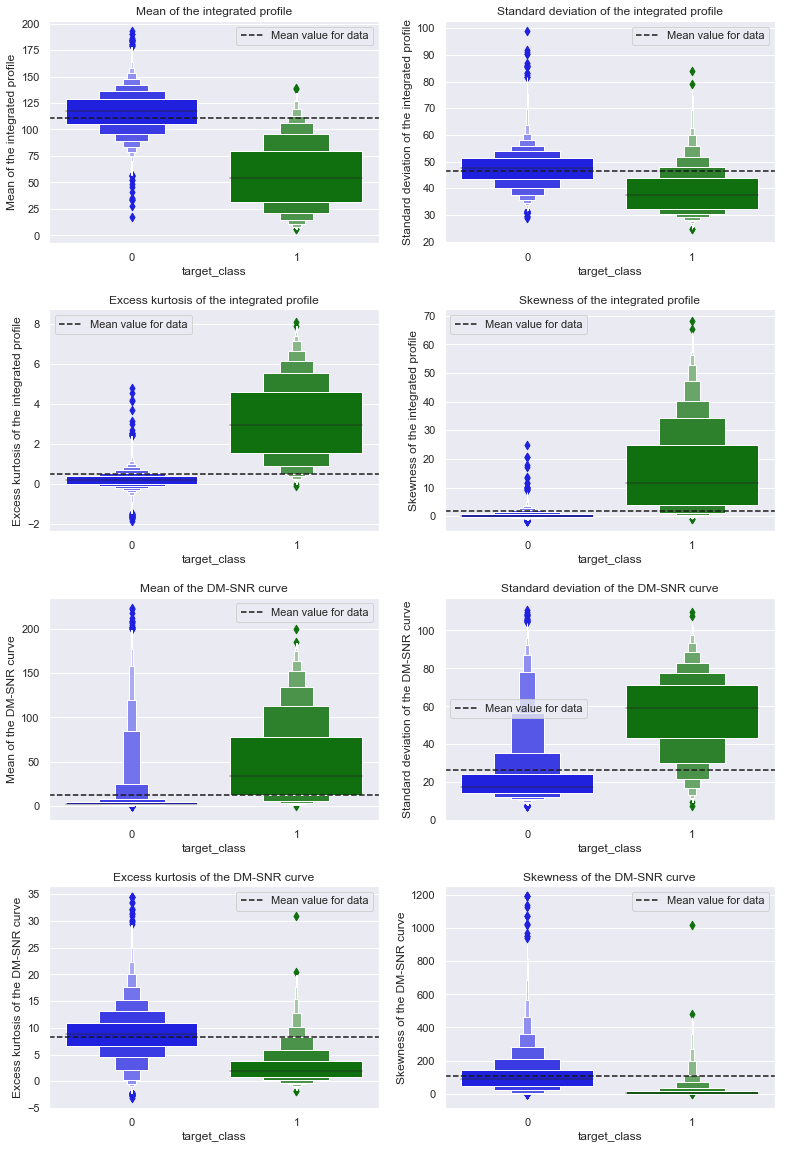

In [7]:
columns = [x for x in dataset.columns if x not in ["target_class"]]
length  = len(columns)
plt.figure(figsize=(13,20))
for i,j in itertools.zip_longest(columns,range(length)):
    plt.subplot(4,2,j+1)
    sns.boxenplot(x=dataset["target_class"],y=dataset[i],palette=["blue","green"])
    plt.title(i)
    plt.subplots_adjust(hspace=.3)
    plt.axhline(dataset[i].mean(),linestyle = "dashed",color ="k",label ="Mean value for data")
    plt.legend(loc="best")

## Normalize numerical attributes

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

for feature in cols:
    dataset[feature] = scaler.fit_transform(dataset[[feature]]) 

## Split data into train and test sets

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

dataset_before_split = dataset.copy()
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(dataset_before_split, dataset_before_split['target_class']):
    strat_train_set = dataset_before_split.loc[train_index]
    strat_test_set = dataset_before_split.loc[test_index]
print('Size of train set = ', len(strat_train_set))
print('Size of test set = ', len(strat_test_set))

Size of train set =  14318
Size of test set =  3580


In [10]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14318 entries, 4644 to 4199
Data columns (total 9 columns):
Mean of the integrated profile                  14318 non-null float64
Standard deviation of the integrated profile    14318 non-null float64
Excess kurtosis of the integrated profile       14318 non-null float64
Skewness of the integrated profile              14318 non-null float64
Mean of the DM-SNR curve                        14318 non-null float64
Standard deviation of the DM-SNR curve          14318 non-null float64
Excess kurtosis of the DM-SNR curve             14318 non-null float64
Skewness of the DM-SNR curve                    14318 non-null float64
target_class                                    14318 non-null int64
dtypes: float64(8), int64(1)
memory usage: 1.1 MB


## Helper Functions

In [22]:
from sklearn import metrics
#https://github.com/rayidghani/magicloops/blob/master/mlfunctions.py
def joint_sort_descending(l1, l2):
    # l1 and l2 have to be numpy arrays
    idx = np.argsort(l1)[::-1]
    return l1[idx], l2[idx]

def generate_binary_at_k(y_scores, k):
    cutoff_index = int(len(y_scores) * (k / 100.0))
    predictions_binary = [1 if x < cutoff_index else 0 for x in range(len(y_scores))]
    return predictions_binary

def precision_at_k(y_true, y_scores, k):
    #y_scores_sorted, y_true_sorted = zip(*sorted(zip(y_scores, y_true), reverse=True))
    y_scores_sorted, y_true_sorted = joint_sort_descending(np.array(y_scores), np.array(y_true))
    preds_at_k = generate_binary_at_k(y_scores_sorted, k)
    #precision, _, _, _ = metrics.precision_recall_fscore_support(y_true, preds_at_k)
    #precision = precision[1]  # only interested in precision for label 1
    precision = metrics.precision_score(y_true_sorted, preds_at_k)
    return precision

def recall_at_k(y_true, y_scores, k):
    #y_scores_sorted, y_true_sorted = zip(*sorted(zip(y_scores, y_true), reverse=True))
    y_scores_sorted, y_true_sorted = joint_sort_descending(np.array(y_scores), np.array(y_true))
    preds_at_k = generate_binary_at_k(y_scores_sorted, k)
    #precision, _, _, _ = metrics.precision_recall_fscore_support(y_true, preds_at_k)
    #precision = precision[1]  # only interested in precision for label 1
    recall = metrics.recall_score(y_true_sorted, preds_at_k)
    return recall

def plot_PR_curve(y_test, y_pred):
    y_score = y_pred
    precision_curve, recall_curve, pr_thresholds = metrics.precision_recall_curve(y_test, y_pred)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_pred)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_pred >= value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set(ylim=(0, 1))

    ax1.set_ylabel('precision', color='b')
    ax2 = ax1.twinx()
    ax1.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    
    #filename = "Pipelevel_Predictions_RF\\"
    #plt.savefig(filename + str(year)+'_precision_recall.png', bbox_inches='tight')
    #plt.close()
    plt.show()

def plot_ROC_curve(y_test, y_pred):
    fpr,tpr,thresholds = metrics.roc_curve(y_test,y_pred)
    roc_auc = metrics.auc(fpr,tpr)
    plt.clf()
    plt.title("ROC")
    plt.plot(fpr,tpr,'b',label='AUC = %0.2f' %roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def print_metrics(y_test, y_pred, k, threshold = 0.5):
    print("Precision", metrics.precision_score(y_test, y_pred > threshold))
    print("Recall",metrics.recall_score(y_test, y_pred > threshold))
    print("F1",metrics.f1_score(y_test, y_pred > threshold))
    print("AUC",metrics.roc_auc_score(y_test, y_pred))
    print("Precision @ ",k," ",precision_at_k(y_test, y_pred > threshold, k))
    print("Recall @ ",k," ",recall_at_k(y_test, y_pred > threshold, k))

In [12]:
X_train = strat_train_set.drop(['target_class'], axis=1).values
y_train = strat_train_set['target_class'].values
X_test = strat_test_set.drop(['target_class'], axis=1).values
y_test = strat_test_set['target_class'].values

## Oversample minority class

~10% of the data belongs to the positive, minority class (is_pulsar). To tackle this calss imbalance, oversample the minority (is_pulsar) instances.

In [13]:
print("Before SMOTE Train set: {}", collections.Counter(y_train))

Before SMOTE Train set: {} Counter({0: 13007, 1: 1311})


In [14]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=10)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)
print("SMOTE Train set: {}", collections.Counter(y_train_sm))

SMOTE Train set: {} Counter({1: 13007, 0: 13007})


## Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier
clf_rf= RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, class_weight="balanced", verbose = 1)
clf_rf.fit(X_train_sm, y_train_sm)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)

### Feature importances

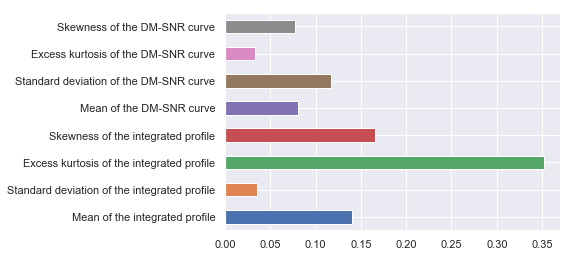

In [16]:
feat_importances = pd.Series(clf_rf.feature_importances_, index=cols)
feat_importances.plot(kind='barh')
plt.show()
#filename = "Pipelevel_Predictions_RF\\"
#plt.savefig(filename + str(year)+'_feature_imp.png', bbox_inches='tight')
#plt.close()

### Evaluation

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy:  0.9751396648044692
Precision 0.8424068767908309
Recall 0.8963414634146342
F1 0.8685376661742983
AUC 0.9695468829688297
Precision @  10   0.8240223463687151
Recall @  10   0.899390243902439


<Figure size 432x288 with 0 Axes>

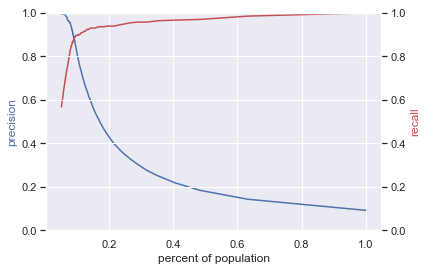

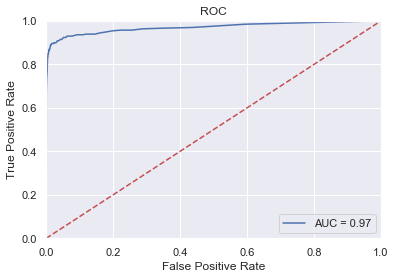

In [23]:
accuracy = clf_rf.score(X_test, y_test)
print("Accuracy: ", accuracy)
y_pred = clf_rf.predict_proba(X_test)[:, 1]
k = 10
print_metrics(y_test,y_pred,k)
plot_PR_curve(y_test, y_pred)
plot_ROC_curve(y_test, y_pred)

### Confusion Matrix

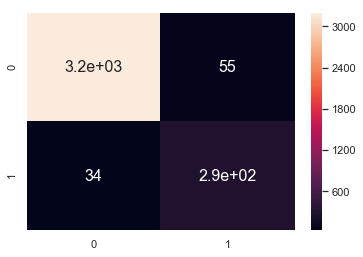

In [18]:
from sklearn.metrics import confusion_matrix
actual_label = y_test
predicted_label = (y_pred>0.5).astype(int)
cm = metrics.confusion_matrix(actual_label,predicted_label)
sns.heatmap(cm, annot=True, annot_kws = {"size": 16})

### Prettier confusion matrix

In [19]:
df_cm = pd.DataFrame(cm, index=["Not_Pulsar","Pulsar"],columns=["Not_Pulsar","Pulsar"])

In [20]:
#https://github.com/wcipriano/pretty-print-confusion-matrix
#imports
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sns


def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1
#

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
#

def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sns.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    plt.show()
#

def plot_confusion_matrix_from_data(y_test, predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='lin'):
    """
        plot confusion matrix function with y_test (actual values) and predictions (predic),
        without a confusion matrix yet
    """
    from sklearn.metrics import confusion_matrix
    from pandas import DataFrame

    #data
    if(not columns):
        #labels axis integer:
        ##columns = range(1, len(np.unique(y_test))+1)
        #labels axis string:
        from string import ascii_uppercase
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

    confm = confusion_matrix(y_test, predictions)
    cmap = 'Oranges';
    fz = 11;
    figsize=[9,9];
    show_null_values = 2
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis)

C:\Users\rutuj\Anaconda3\envs\deepmlenv\lib\site-packages\ipykernel_launcher.py:50: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


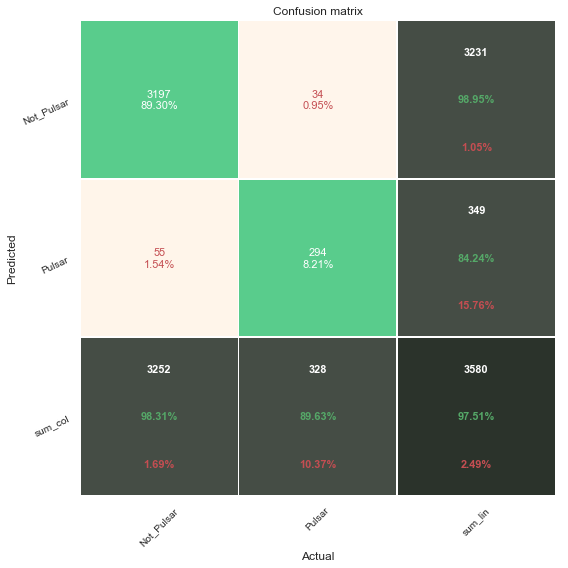

In [21]:
pretty_plot_confusion_matrix(df_cm)

### K-fold cross validation with Logistic Regression

In [32]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
dataset_before_split = dataset.copy()

kf = StratifiedKFold(n_splits=5, random_state=2018)
k = 0

X = dataset_before_split.drop(['target_class'], axis=1)
targets = dataset_before_split['target_class'].values

# Keep some things after each loop
val_auc_scores =  []
val_preds = []
val_true = []
for train_idx, val_idx in kf.split(X, targets):
#Select the dat for this fold
    X_train, y_train = X.loc[train_idx, :], targets[train_idx]
    X_val, y_val = X.loc[val_idx, :], targets[val_idx]

#Oversampling minority class   
    sm = SMOTE(random_state=10)
    X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

# Fit a model    
    model = LogisticRegression()
    model.fit(X_train_sm, y_train_sm)
    
#Get the prediction probabilities 
    val_probs = model.predict_proba(X_val)[:, 1]
    train_probs = model.predict_proba(X_train)[:, 1]
    
#Calculate ROC AUC
    train_auc = roc_auc_score(y_train, train_probs)
    val_auc = roc_auc_score(y_val, val_probs)
    
#Keep track of val auc
    val_auc_scores.append(val_auc)
    
    print(f'Fold: {k}')
    print(f'\tTrain AUC: {train_auc}\n\tVal AUC: {val_auc} ')
    
    k += 1
    
    val_preds.extend(model.predict(X_val))
    val_true.extend(y_val)
    
print(f'\nMean Validation ROC AUC: {np.mean(val_auc_scores)}')

C:\Users\rutuj\Anaconda3\envs\deepmlenv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rutuj\Anaconda3\envs\deepmlenv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold: 0
	Train AUC: 0.9784426352130874
	Val AUC: 0.9720134701347014 
Fold: 1
	Train AUC: 0.9771503075531061
	Val AUC: 0.9790166651666518 


C:\Users\rutuj\Anaconda3\envs\deepmlenv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rutuj\Anaconda3\envs\deepmlenv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold: 2
	Train AUC: 0.9779485047569
	Val AUC: 0.9744078690786908 
Fold: 3
	Train AUC: 0.9769215391090533
	Val AUC: 0.9784382218822189 
Fold: 4
	Train AUC: 0.9762497234347344
	Val AUC: 0.9801077438416973 

Mean Validation ROC AUC: 0.9767967940207919


C:\Users\rutuj\Anaconda3\envs\deepmlenv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C:\Users\rutuj\Anaconda3\envs\deepmlenv\lib\site-packages\ipykernel_launcher.py:50: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


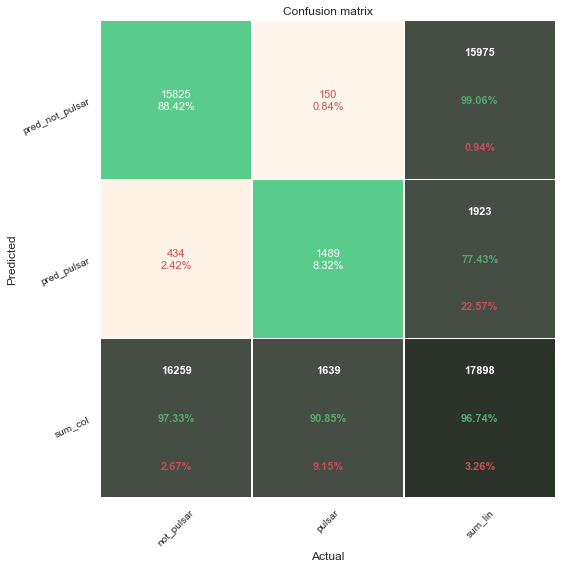

In [34]:
df_cm_lr = pd.DataFrame(confusion_matrix(val_true, val_preds, labels=[0,1]))
df_cm_lr.columns = ['pred_not_pulsar','pred_pulsar']
df_cm_lr.index = ['not_pulsar','pulsar']
pretty_plot_confusion_matrix(df_cm_lr)